In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from statistics import mean
import copy

In [42]:
# Read data and then split into training and test. Training takes first n years where n is the parameter
# Returns whole data, train and test data

# (filepath: string, numOfTrainYears: int) => (df_whole: DataFrame, df_train: DataFrame, df_validation: DataFrame, df_insample: DataFrame, df_out_of_sample: DataFrame)
def read_and_split(filepath, numOfTrainYears, numOfInsampleYears):
    df_whole= pd.read_csv(filepath)
    df_whole['Date'] = pd.to_datetime(df_whole['Date'])
    years = df_whole['Date'].map(lambda x : x.year)
    minYear = years.min()
    df_train = df_whole[years <= minYear+numOfTrainYears]
    df_validation = df_whole[(years > minYear+numOfTrainYears) & (years <= minYear+numOfInsampleYears)]
    df_insample = df_whole[years <= minYear + numOfInsampleYears]
    df_outofsample = df_whole[years > minYear + numOfInsampleYears]
    return (df_whole, df_train, df_validation, df_insample, df_outofsample)

In [3]:
# Returns series of boolean. Days which are true are the ones on which a "crossover" is registered 

# (ser: Series[Double], shortSignal: Int, longSignal: Int) => (ranges: Series[Bool])
def crossover(ser, shortSignal, longSignal):
    smaShort = ser.rolling(window = shortSignal).mean().iloc[longSignal:]
    smaLong = ser.rolling(window = longSignal).mean().iloc[longSignal:]
    changes = (smaShort <= smaLong)
    changesShifted = changes.shift()
    ranges = (changes != changesShifted)
    return ranges

In [4]:
# Forms a linear regression model for a given dataframe and array of absolute errors (one for each point).
# Model represents price as a function of time

# (ser: Series[Double], plot_flage: boolean) => (model: LinearRegressionModel, ape: np.array[Double])
def LinearRegressionModel(df, plot_flag = False):
    ser = df['Close']
    model = LinearRegression()
    model.fit(np.array(ser.index).reshape(-1,1), ser)
    prediction = np.array(model.predict(np.array(ser.index).reshape(-1,1)))
    if plot_flag:
        plt.plot(df['Date'], ser, c='orange')
        plt.plot(df['Date'], prediction, c='blue')
    ape = abs((np.array(ser) - prediction)/np.array(ser))
    return (model, ape)

In [10]:
# Returns a list of linear regression models on consecutive slices of the input series and a list of arrays (one for each slice)
# of abs. errors (one for each data point in the slice). Ranges is a series of boolean that recognizes begining of the slice for
# the next model (true for the begining of the new  model, false otherwise)
# This is used only for training data

# (df: DataFrame, ranges: Series[Bool], plot_flag: boolean) => (List[LinearRegressionModels], List[List[Double]])
def linearRegressionModels(df, ranges, plot_flag = False):
    models = []
    apes = []
    previous_i = 0
    for i in ranges.index:
        if ranges.loc[i]:
            curr_ser = df.iloc[previous_i: i]
            model, apes = LinearRegressionModel(curr_ser, plot_flag)
            apes.append(ape)
            models.append(model)
            previous_i = i

    curr_ser = df.iloc[previous_i:]
    model, ape = LinearRegressionModel(curr_ser, plot_flag)
    apes.append(ape)
    models.append(model)
    return (models, apes)

In [12]:
# Using KNN to predict Close price for the next day
# K nearest neighbours are those that are the most similar based on returns values (return for today is the difference between today's and yesterday's price)
# (df: dfFrame, atributeForPrediction: string, numOfNeighbors: Int) => Double
def predictNext(df, atributeForPrediction, numOfNeighbors):
    data = df.diff().iloc[1:]
    currentPointIndex = data.shape[0] -1
    nbrs = NearestNeighbors(n_neighbors=numOfNeighbors).fit(np.array(data))
    distances, indices = nbrs.kneighbors(np.array(data))
    mask = list(map(lambda x: x != currentPointIndex, indices[currentPointIndex]))
    nIndices = np.array(list(filter(lambda i : mask[i], range(0, numOfNeighbors)))) + 1
    nDistances = np.array(list(filter(lambda i : mask[i], range(0, numOfNeighbors))))+1
    neighbours = np.array(data[atributeForPrediction].iloc[nIndices]) / nDistances
    return df[atributeForPrediction].iloc[-1]+sum(neighbours) / sum(1/nDistances)

In [13]:
# Creates predictions for each point in test data

# (df_whole: DataFrame, df_test: DataFrame, numOfNeigh: Int) => Series[Double]
def create_price_predictions(df_whole, df_test, numOfNeigh):
    pricePredictionOnTest = []
    predictionData = df_whole.drop(['Date', 'Volume'], axis =1)
    for date in df_test['Date']:
        dataPredictionSlice = predictionData[df_whole['Date'] < date]
        pricePredictionOnTest.append(predictNext(dataPredictionSlice, 'Close', numOfNeigh))

    pricePredictionOnTest = pd.Series(pricePredictionOnTest, index = df_test.index)
    return pricePredictionOnTest

In [83]:
# Create models for train data

# (df_whole: DataFrame, df_train: DataFrame, ranges: Series[Bool], plot: boolean) => (List[LinearRegressionModels], List[List[Double]], DataFrame)
def create_train_models(df_whole, df_train, ranges, plot=False):
   
    # Make linear regression models on training period
    models, apes = linearRegressionModels(df_train, ranges, plot)
    # Calculate the data frame for the last linear regression
    last_slice_index = ranges[ranges].index[-1] if ranges[ranges].shape[0] > 0 else 0
    last_slice = df_train.loc[last_slice_index:]
    
    return models, apes, last_slice

In [52]:
# Creates models for test data and signals for trades. If signal is:
#   a) positive -> buy
#   b) negative -> sell
#   c) zero -> no trade

# (df_whole: DataFrame, df_test: DataFrame, n_neighbours: Int, models: List[LinearRegressionModels],
# apes: List[List[Double]], last_train_slice: DataFrame, adjusment_period: Int, plot: boolean
def create_test_models(df_whole, df_test, n_neighbours,
                       models, apes, last_train_slice,
                       ajdustment_period = 40, plot=False):
    # Get price prediction for each day in test
    pricePredictionOnTest = create_price_predictions(df_whole, df_test, n_neighbours)
    
    # Slice of data for the current lin. reg. model (current trend)
    data = last_train_slice.copy()
    # Initialize trade signals with zeroes
    trade_signals = pd.Series(0.0, index=df_test.index)
    prev_signal = 0
    prev_i = 0
    
    # For every day check if we should have a signal for buy/trade and update list of linear regression models
    for i in range(0, df_test.shape[0]):
        index = df_test.index[i]
        # Append a prediction on the current slice and update the model
        data.at[index, 'Close'] = pricePredictionOnTest[index]
        model, ape = LinearRegressionModel(data, False)
        
        general_mean_ape = np.concatenate(apes).ravel().mean()
        # If model's error becomes bigger than average error of all models, start a new model
        if ape.mean() > general_mean_ape:
            model, ape = LinearRegressionModel(data.iloc[-2:])
            # Whenever a new linear regression model is started, make a signal for the next day
            trade_signals[index] = model.coef_[0]
            prev_i = index
            prev_signal = trade_signals[index]
            if plot:
                dates = data['Date'].iloc[:-1]
                prediction = np.array(models[-1].predict(np.array(data.iloc[:-1].index).reshape(-1,1)))
                plt.plot(dates, data['Close'].iloc[:-1], c='orange', zorder=0)
                plt.plot(dates, prediction, c='purple', zorder=5)
                if models[-1].coef_[0] > 0:
                    m = 'o'
                else:
                    m = 'd'
                plt.scatter(df_test['Date'].loc[index], df_test['Close'].loc[index],
                            c='black', marker=m, zorder=10)
            # Take a new slice of data (it consists of two points: current and previous day)
            data = df_whole.loc[index-1:index+1].copy()
            # Make a new model
            model, ape = LinearRegressionModel(data)
            # Append the new model
            models.append(model)
            apes.append(apes)
        # Otherwise, update the current model and it's slice with today's price
        else:
            # If previous signal and current coef are not of the same sign and adjusment period is over, create a trade signal
            # Adjustment period is a period after a signal that can't have a signal that's not at the beggining of a linear regression
            # In other words, we are allowed to have a signal inside a linear regression (that's not at the beginning) only if enough days have passed
            if prev_signal*models[-1].coef_[0] <= 0.0 and index - prev_i >= ajdustment_period:
                trade_signals[index] = models[-1].coef_[0]
                prev_i = index
                prev_signal = trade_signals[index]
                if plot:
                    if models[-1].coef_[0] > 0:
                        m = 'o'
                    else:
                        m = 'd'
                    plt.scatter(df_test['Date'].loc[index], df_test['Close'].loc[index],
                            c='black', marker=m, zorder=10)
            # Update current slice with the current date
            data = df_whole.loc[data.index[0]:index+1].copy()
            # Make a new model
            model, ape = LinearRegressionModel(data)
            # Update error and model in lists of errors and models
            apes[-1] = apes
            models[-1] = model
            
    if plot:
        plt.show()
        
    return trade_signals, models, apes, data

In [32]:
# Calculate number of stocks to trade in a trade signal

# (k: double, capital: double, close: double, prev_num_of_stocks: int) => (stocks_to_trade: int)
def calculateAmount(k, capital, close, prev_num_of_stocks):
    
    # Coef should be between 0 and 1 and since k can be greater than 1, adjusment is needed
    # A sigmoid function can be used here, but not many times will k be greater than 1 and it will never be much greater, and therefore all coefs would be close to zero
    coef = np.sign(k)*min(1, abs(k))
   
    # Stocks to trade should be between 0 and maximum possible number that we can trade with our capital
    # When we are selling, we can comfortably consider 
    size_of_trade_criteria = capital
    isSell = k < 0
    if isSell:
        size_of_trade_criteria = (capital+close*prev_num_of_stocks)
       
    # Calculate number of stocks to trade and holding days
    stocks_to_trade = (coef*size_of_trade_criteria)//close
       
    return stocks_to_trade

In [59]:
# Simulate trading over time.
# Resulting state consists of capital (cash), number of stocks, total capital (which is
# capital+ number of stocks*last closing price)

# (trade_signals: Series[Int], initial_capital: Double, transaction_cost: Double, close_prices: Series[Double]) => (Double, Double, Int)
def trading(trade_signals, close_prices, transaction_cost,
            initial_capital = 100000, initial_num_of_stocks = 0):
    # Current equity state: capital = 100 000, num_of_stocks = 0, total_capital = capital
    # State will vary as time passes
    capital = initial_capital
    num_of_stocks = initial_num_of_stocks
    total_capital = initial_capital
    i = 0
   
    for index in close_prices.index:
        # Append current state to global list of states (for plotting)
        list_of_capitals.append(capital)
        list_of_num_of_stocks.append(num_of_stocks)
        # If there is a signal for trade
        if trade_signals[index] != 0:
            i +=1
            # Calculate amount to trade
            stocks_to_trade = calculateAmount(trade_signals[index], (1-transaction_cost)*capital,
                                              close_prices[index], num_of_stocks)

            #Update equity state
            capital -= stocks_to_trade*close_prices[index]*(1+np.sign(trade_signals[index])*transaction_cost)
            num_of_stocks += stocks_to_trade
            total_capital = capital+num_of_stocks*close_prices[index]

    total_capital = capital+num_of_stocks*close_prices.iloc[-1]
    return (total_capital, capital, num_of_stocks)

In [34]:
# Calculate sharpe ratio
def sharpe_ratio(close_prices, stocks):
    returns = stocks[1:]*close_prices.diff().iloc[1:]
    mean = returns.mean()
    std = returns.std()
    return mean/std

In [35]:
# Plot a feature of a df 
def plot(df, list_to_plot, feature_name):
    plt.plot(df['Date'], list_to_plot)
    plt.xlabel('date')
    plt.ylabel(feature_name)

In [ ]:
df_whole, df_train, df_validation, df_insample, df_out_of_sample = read_and_split('../data/SPY.csv', 1, 14)

In [114]:
# Analyze how short and long parameters affect number of linear regressions
list_of_errs = []
for short in range(10, 50, 10):
    for long in range(short+10, 100, 10):
        ranges = crossover(df_train['Close'], short, long)
        fig = plt.figure(figsize=(8, 3), dpi=150)
        models, apes = linearRegressionModels(df_train, ranges, True)
        fig.savefig('../LR_figs/short_' + str(short) + '_long_' + str(long), dpi=200) 
        #plt.show()
        plt.close()
        flattened  = [val for sublist in apes for val in sublist]
        list_of_errs.append([short, long, np.array(flattened).mean()])
df_errors = pd.DataFrame(list_of_errs, columns=['short', 'long', 'errors'])
df_errors.to_csv('../results/lr_errors.csv')

In [112]:
# Analyze how number of neighbours affects prediction error
list_of_prediction_errs = []
for numOfNeigh in range(3,12):
    prediction = create_price_predictions(df_insample, df_validation, numOfNeigh)
    fig = plt.figure(figsize=(6, 3), dpi=150)
    plt.plot(df_validation['Date'], df_validation['Close'], c='orange')
    plt.plot(df_validation['Date'], prediction, c='blue')
    fig.savefig('../KNN_prediction/numOfNeigh_' + str(numOfNeigh), dpi=200) 
    plt.close()
    mape = abs((np.array(df_validation['Close']) - prediction)/np.array(df_validation['Close'])).mean()
    list_of_prediction_errs.append([numOfNeigh, mape])
df_prediction_errors = pd.DataFrame(list_of_prediction_errs, columns=['numOfNeigh', 'prediction errors'])
df_prediction_errors.to_csv('../results/knn_errors.csv')
#df_prediction_errors*100/df_test.shape[0]

In [1]:
# Run the trading simulator for different meta parameters on train and validation sets
# The best parameters are determined by best sharpe ratio
initial_capital = 100000
transaction_cost = 0.05
numNeigh = 5
df_whole, df_train, df_validation, df_insample, df_out_of_sample = read_and_split('../data/SPY.csv', 1, 14)
results = []
for longSignal in range(20, 520, 20):
    for shortSignal in range(10, longSignal+10, 20):
        for adjustment_period in range(20, 100, 20):
            ranges_train = crossover(df_train['Close'], shortSignal, longSignal)
            models, apes, last_slice = create_train_models(df_insample, df_train, ranges_train, False)
            trade_signals, models, apes, current_slice = create_test_models(df_insample, df_validation, numNeigh,
                                                                                        models, apes, last_slice, adjustment_period, False)

            list_of_capitals = []
            list_of_num_of_stocks = []
            total_capital, capital, num_of_stocks = trading(trade_signals, df_validation['Close'], transaction_cost, initial_capital, 0)
            list_of_total_capital = np.array(list_of_num_of_stocks)*df_validation['Close'] + np.array(list_of_capitals)

            end_position = num_of_stocks*df_validation['Close'].iloc[-1]
            sr = sharpe_ratio(df_validation['Close'], list_of_num_of_stocks)
            results.append([adjustment_period, shortSignal, longSignal, total_capital, capital, num_of_stocks, end_position, sr])

            fig = plt.figure(figsize=(6, 3), dpi=150)
            plot(df_validation, list_of_num_of_stocks, 'stocks')
            fig.savefig('../figures/adjPer_'+str(adjustment_period)+'_long_'+str(longSignal)+'_short_'+str(shortSignal)+'_stocks.png', dpi=200)
            plt.close()

            fig = plt.figure(figsize=(6, 3), dpi=150)
            plot(df_validation, list_of_capitals, 'capital')
            fig.savefig('../figures/adjPer_'+str(adjustment_period)+'_long_'+str(longSignal)+'_short_'+str(shortSignal)+'_capital.png', dpi=200)
            plt.close()

            fig = plt.figure(figsize=(6, 3), dpi=150)
            plot(df_validation, list_of_num_of_stocks*df_validation['Close'], 'position value')
            fig.savefig('../figures/adjPer_'+str(adjustment_period)+'_long_'+str(longSignal)+'_short_'+str(shortSignal)+'_position value.png', dpi=200)
            plt.close()

            fig = plt.figure(figsize=(6, 3), dpi=150)
            plot(df_validation, list_of_total_capital, 'total capital')
            
            # Plot of buy and hold strategy
            buy_and_hold = df_validation['Close']*(1-transaction_cost)*initial_capital//df_validation['Close'].iloc[0]
            plot(df_validation, buy_and_hold, 'total capital')
            fig.savefig('../figures/adjPer_'+str(adjustment_period)+'_long_'+str(longSignal)+'_short_'+str(shortSignal)+'_total capital.png', dpi=200)
            plt.close()
            # print(adjustment_period, longSignal, shortSignal, np.sum(trade_signals != 0))
       
    
df_results = pd.DataFrame(results,
                          columns=['AdjustmentPeriod', 'ShortSig', 'LongSig',
                                   'TotalCap', 'Capital', 'NumOfStocks', 'Position', 'SR'])
df_results.to_csv('../results/results.csv')

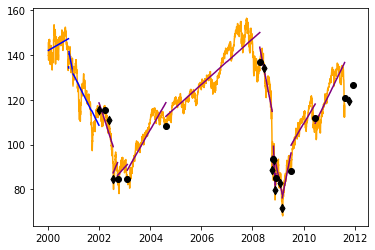

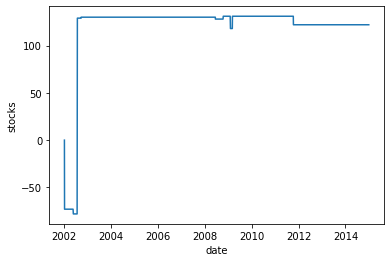

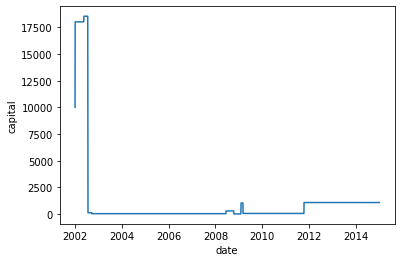

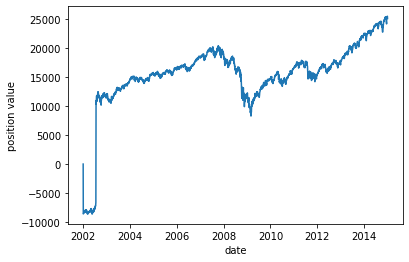

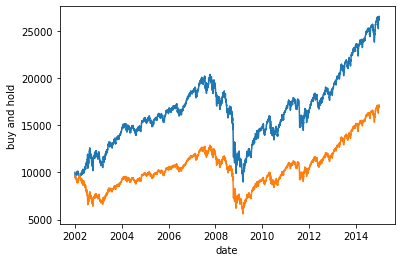

In [93]:
# Run the trading simulator for train and validation sets again for the best parameters
initial_capital = 10000
transaction_cost = 0.05
numNeigh = 5
shortSignal = 190
longSignal = 200
list_of_capitals = []
list_of_num_of_stocks = []
adjustment_period = 40
df_whole, df_train, df_validation, df_insample, df_out_of_sample = read_and_split('../data/SPY.csv', 1, 14)
ranges_train = crossover(df_train['Close'], shortSignal, longSignal)
models, apes, last_slice = create_train_models(df_insample, df_train, ranges_train, True)
trade_signals, models, apes, current_slice = create_test_models(df_insample, df_validation, numNeigh,
                                                                            models, apes, last_slice,
                                                                            adjustment_period, True)
total_capital, capital, num_of_stocks = trading(trade_signals, df_validation['Close'], transaction_cost,
                                                initial_capital, 0)

list_of_total_capital = np.array(list_of_num_of_stocks)*df_validation['Close'] + np.array(list_of_capitals)

plot(df_validation, list_of_num_of_stocks, 'stocks')
plt.show()

plot(df_validation, list_of_capitals, 'capital')
plt.show()

plot(df_validation, list_of_num_of_stocks*df_validation['Close'], 'position value')
plt.show()

plot(df_validation, list_of_total_capital, 'total capital')
buy_and_hold = df_validation['Close']*(1-transaction_cost)*initial_capital//df_validation['Close'].iloc[0]
plot(df_validation, buy_and_hold, 'buy and hold')
plt.show()

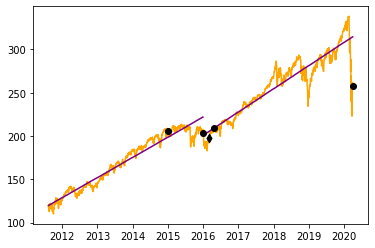

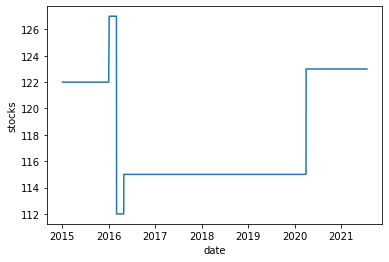

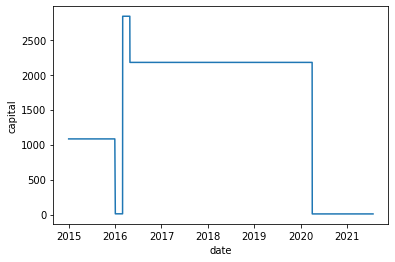

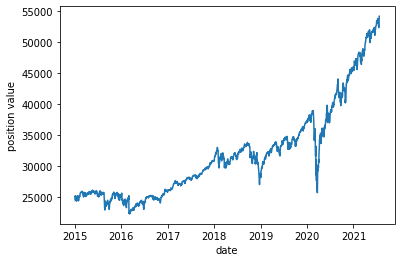

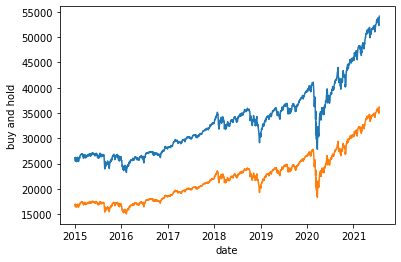

In [94]:
# Run the trading simulation on out of sample (test) set for the best parameters
old_list_of_capitals = copy.deepcopy(list_of_capitals)
old_list_of_num_of_stocks = copy.deepcopy(list_of_num_of_stocks)
old_list_of_total_capital = copy.deepcopy(list_of_total_capital)
list_of_capitals = []
list_of_num_of_stocks = []
list_of_total_capital = []
trade_signals, models, apes, current_slice = create_test_models(df_whole, df_out_of_sample, numNeigh,
                                                                            models, apes, current_slice,
                                                                            adjustment_period, True)
total_capital, capital, num_of_stocks = trading(trade_signals, df_out_of_sample['Close'], transaction_cost,
                                                old_list_of_capitals[-1], old_list_of_num_of_stocks[-1])

list_of_total_capital = np.array(list_of_num_of_stocks)*df_out_of_sample['Close'] + np.array(list_of_capitals)

plot(df_out_of_sample, list_of_num_of_stocks, 'stocks')
plt.show()

plot(df_out_of_sample, list_of_capitals, 'capital')
plt.show()

plot(df_out_of_sample, list_of_num_of_stocks*df_out_of_sample['Close'], 'position value')
plt.show()

plot(df_out_of_sample, list_of_total_capital, 'total capital')
buy_and_hold = df_out_of_sample['Close']*(1-transaction_cost)*initial_capital//df_validation['Close'].iloc[0]
plot(df_out_of_sample, buy_and_hold, 'buy and hold')
plt.show()

In [101]:
# Calculate sharpe ratio on out of sample for our model and for buy and hold strategy
sr = sharpe_ratio(df_out_of_sample['Close'], list_of_num_of_stocks)
sr_index = sharpe_ratio(df_out_of_sample['Close'], np.full(df_out_of_sample.shape[0],(1-transaction_cost)*initial_capital//df_validation['Close'].iloc[0]))
print(sr, sr_index)

0.04675804002608323 0.045818904091937895
